In [2]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
class Dataloader:
    def __iter__(self):
        for genre in tqdm(['ballads', 'elegies', 'songs', 'novels'], leave=True):
            for file in tqdm(os.listdir('../datasets/lemmatized/' + genre), leave=False):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    yield utils.simple_preprocess(f.read())
sentences = Dataloader()

In [ ]:
word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size=128, min_count=1)

In [4]:
#word2vec.save('word2vec_model')
word2vec = gensim.models.Word2Vec.load('word2vec_model')

In [5]:
word2vec.wv.most_similar(positive='царь', topn=10)

[('король', 0.823395848274231),
 ('царевич', 0.8209406137466431),
 ('патриарх', 0.8094379901885986),
 ('престол', 0.7853482365608215),
 ('государь', 0.7745516300201416),
 ('император', 0.7719162106513977),
 ('иоанн', 0.7696580290794373),
 ('владыка', 0.7589395642280579),
 ('православный', 0.7550569772720337),
 ('годунов', 0.7452263832092285)]

In [ ]:
graphs = []
for sentence in sentences:
    if not sentence:
        continue
    adj = kneighbors_graph(word2vec.wv[sentence], n_neighbors=5, metric='minkowski', p=2)
    graph = nx.from_scipy_sparse_array(adj)
    mapping = {i: token for i, token in enumerate(sentence)}
    graph = nx.relabel_nodes(graph, mapping)
    graph.remove_edges_from(nx.selfloop_edges(graph))
    graphs.append(graph)

In [17]:
from collections import Counter
from time import time

graphs = []
t0 = time()
for sentence in sentences:
    if not sentence:
        continue
    nodes = []
    top10 = Counter(sentence).most_common(10)
    for word, freq in top10:
        top10_wv = word2vec.wv.most_similar(positive=word, topn=10)
        nodes.append(word)
        for syn, vec in top10_wv:
            nodes.append(syn)
    adj = kneighbors_graph(word2vec.wv[nodes], n_neighbors=5, metric='minkowski', p=2)
    graph = nx.from_scipy_sparse_array(adj)
    mapping = {i: token for i, token in enumerate(nodes)}
    graph = nx.relabel_nodes(graph, mapping)
    graph.remove_edges_from(nx.selfloop_edges(graph))
    graphs.append(graph)

print(f"graphs build in {time() - t0:.3f} s")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

graphs build in 462.907 s


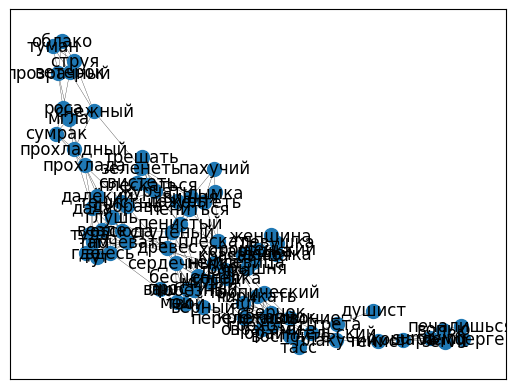

In [18]:
nx.draw_networkx(graphs[0], node_size=100, width=0.2)
#plt.xlim(-0.07, 0.03)
#plt.ylim(-0.05, 0.05)

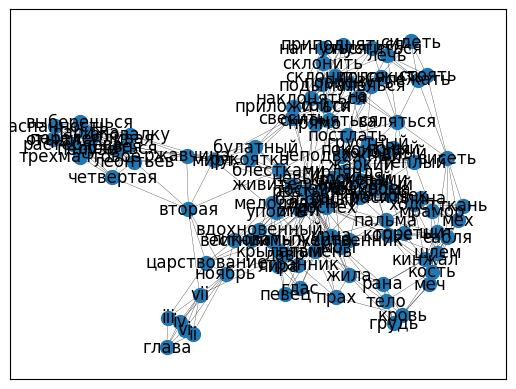

In [26]:
nx.draw_networkx(graphs[1], node_size=100, width=0.2)

In [ ]:
sent_len = [len(sent) for sent in sentences if sent]

In [39]:
print(len(graphs))
print(len(sent_len))

1826
1826


In [46]:
from tqdm import tqdm

sent_features = []

for num, graph in tqdm(enumerate(graphs)):
    text_len = sent_len[num]
    node_num = len(graph.nodes)
    edge_num = len(graph.edges)
    avg_clust_coef = nx.average_clustering(graph)
    largest_cc = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()
    radius = nx.radius(largest_cc)
    diameter = nx.diameter(largest_cc)
    shortest_path_len = nx.average_shortest_path_length(largest_cc)
    avg_node_con = nx.average_node_connectivity(graph)
    #degree_cent = nx.degree_centrality(graph)
    #closeness = nx.closeness_centrality(graph)
    #betweenness = nx.betweenness_centrality(graph)
    #eigen = nx.eigenvector_centrality(graph)
    #katz = nx.katz_centrality_numpy(graph)
    features = [text_len, node_num, edge_num, avg_clust_coef, radius, diameter, shortest_path_len, avg_node_con]
    sent_features.append(features)

1826it [18:46:48, 37.03s/it] 


In [58]:
true_labels = []

class Genres:
    def __iter__(self):
        for genre in tqdm(['ballads', 'elegies', 'songs', 'novels'], leave=True):
            for file in tqdm(os.listdir('../datasets/lemmatized/' + genre), leave=False):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    if utils.simple_preprocess(f.read()):
                        yield genre
genres_true = Genres()

for gen in genres_true:
    true_labels.append(gen)

100%|██████████| 4/4 [01:02<00:00, 15.71s/it]


In [59]:
len(true_labels)

1826

In [73]:
import pickle

with open('sent_features.pickle', 'wb') as f:
    pickle.dump(sent_features, f)

#with open('sent_features.pickle', 'rb') as f:
#    sent_features = pickle.load(f)

with open('true_labels.pickle', 'wb') as f:
    pickle.dump(true_labels, f)

#with open('true_labels.pickle', 'rb') as f:
#    true_labels = pickle.load(f)

In [60]:
from collections import defaultdict
from sklearn import metrics
import numpy as np

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(true_labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(true_labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(true_labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(true_labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [61]:
from sklearn.cluster import KMeans

X = np.array(sent_features)

kmeans = KMeans(
    n_clusters=4,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X)

clustering done in 0.02 ± 0.01 s 
Homogeneity: 0.359 ± 0.007
Completeness: 0.622 ± 0.009
V-measure: 0.455 ± 0.008
Adjusted Rand-Index: 0.258 ± 0.007
Silhouette Coefficient: 0.837 ± 0.002
